In [1]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from z3 import *
from scipy.ndimage import measurements
from IPython.display import Markdown, display,Image,HTML

The grid presented here can be partitioned into 9 L-shaped “hooks”. The largest
is 9-by-9 (contains 17 squares), the next largest is 8-by-8 (contains 15
squares), and so on. The smallest hook is just a single square. Find where the
hooks are located, and place nine 9’s in the largest hook, eight 8’s in the
next-largest, etc., down to one 1 in the smallest hook. The filled squares must form a connected region. (Squares are “connected” if
they are orthogonally adjacent.) A number outside the grid indicates the sum of the products of consecutive
groups of squares in that row or column. (As shown in the example. The answer to this puzzle is the product of the areas of the connected groups of
empty squares in the completed grid.

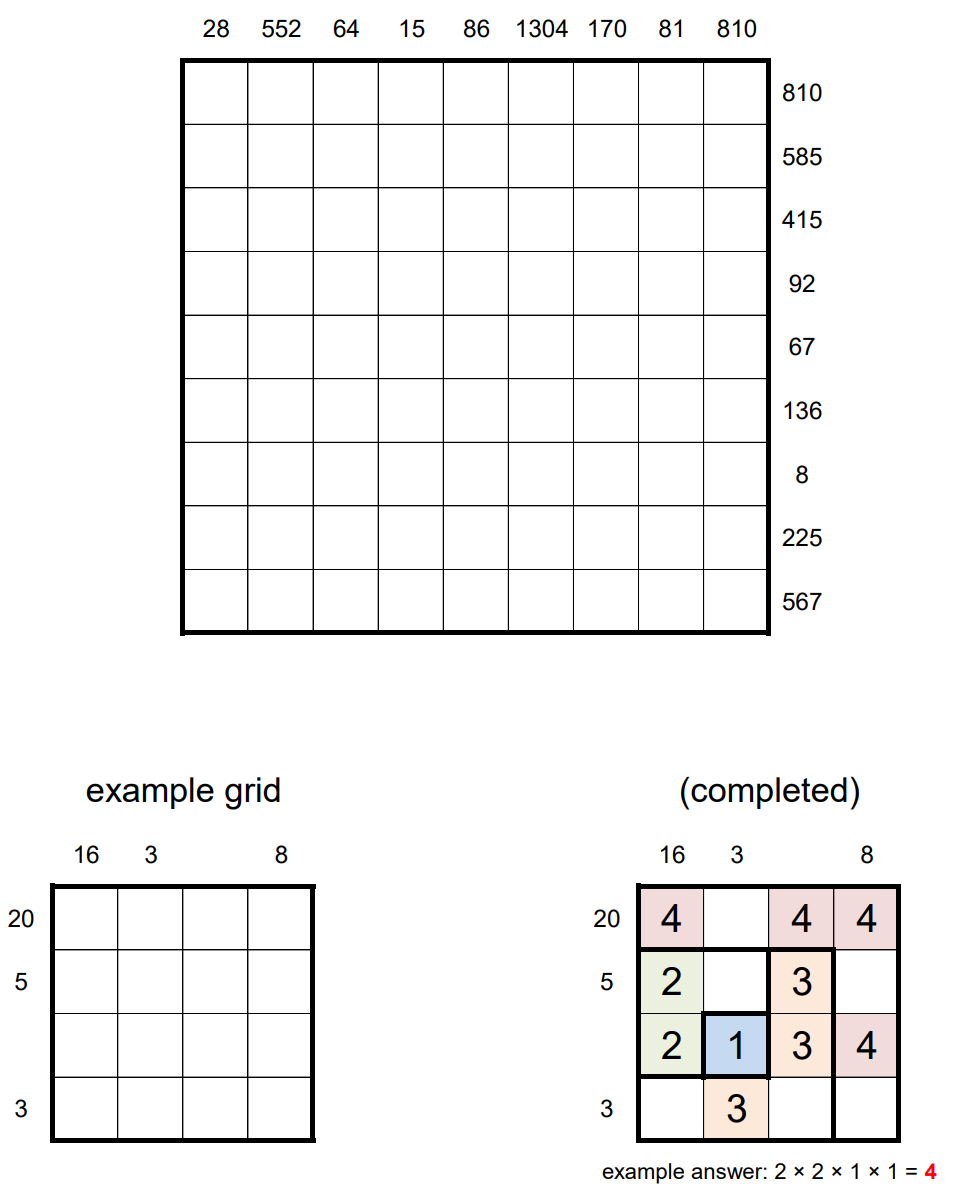

In [2]:
url='https://www.janestreet.com/puzzles/hooks-4-index/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(x)])
display(Markdown(" ".join(x[11:15])))
display(Image('https://www.janestreet.com/puzzles/aug18_puzzle_bold.png',width=400))

In [3]:
#Setup the constraints
top_labels = [28,552,64,15,86,1304,170,81,810]
right_labels =[810,585,415,92,67,136,8,225,567]
params=[top_labels,right_labels]

In [4]:
def sol_print(solved,matrix):
    fig,ax = plt.subplots(1,1,figsize=(4,4))
    x = np.array((solved*matrix).astype('int').astype('str'))
    x[x=="0"] =""
    ax =sns.heatmap(solved,annot=x,cbar=False,cmap="tab10",fmt="",linewidths=2,linecolor='k',annot_kws={"fontsize":12,"color":"k"},alpha=.6)
    ax.tick_params(left=False, bottom=False,labelleft=False, labelright=True)
    ax.axis("off")
    plt.tight_layout()
    plt.show()

In [5]:
def neigh(x,y,N):
    return [(i+x,j+y) for i,j in [(-1,0),(0,-1),(1,0),(0,1)] if i+x >=0 and i+x <N and j+y >=0 and j+y <N]

def areas(grid):
    labels, num = measurements.label(np.logical_not(grid!=0))
    areas = measurements.sum(np.logical_not(grid!=0), labels, index=range(1, num+1))
    print(areas)
    return np.prod(areas)

def numbers(split,line,hook_line):
    block = 0
    inblock =0
    for n,p in enumerate(split):         
        if p ==1:
            if inblock == 0:
                block += line[n]*hook_line[n]
                inblock = 1
            else:
                block *= line[n]*hook_line[n]         
        else:
            if inblock == 1:
                yield block
                block = 0
                inblock = 0                    
    if inblock == 1:
        yield block
            
def constraint(line,hook_line,split,param):
    nums =[i for i in numbers(split,line,hook_line)]
    return Implies(And([line[i] == int(e) for i,e in enumerate(split)]),Sum(nums) == param)

In [6]:
test_grid =np.array([[1,1,0,0,0,0,1,1,1],
             [0,1,1,0,1,1,1,0,1],
             [0,0,1,1,1,0,0,1,1],
             [1,1,0,0,0,0,1,1,0],
             [0,1,1,0,0,1,1,0,0],
             [1,1,0,1,1,1,0,0,0],
             [0,1,0,0,0,1,0,0,0],
             [1,1,1,0,1,1,1,0,1],
             [1,0,1,1,1,0,1,1,1]
             ])

test_hook =np.array([[9,9,9,9,9,9,9,9,9],
             [8,8,8,8,8,8,8,8,9],
             [7,7,7,7,7,7,7,8,9],
             [6,6,6,6,6,6,7,8,9],
             [5,5,5,5,5,6,7,8,9],
             [4,4,4,4,5,6,7,8,9],
             [3,2,2,4,5,6,7,8,9],
             [3,2,1,4,5,6,7,8,9],
             [3,3,3,4,5,6,7,8,9]
             ])

setup done in 10.88 seconds


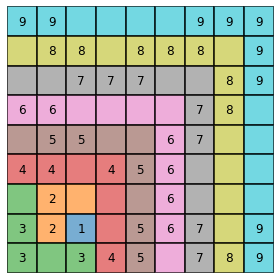

Took 2828.2531 seconds
[ 5.  3.  1.  8. 10.  1.  5.  1.  1.  1.]
solution is 6,000


In [9]:
start = time.time()
N =9
#set up the solver and variables.
s = Tactic("qffd").solver()

# H== hooks
H = np.array(IntVector("h",N**2),dtype=object).reshape((N,N))

row_fix =IntVector("r",N)
col_fix =IntVector("c",N)

s += [And(e>0,e<=N) for (i,j),e in np.ndenumerate(H)]
s += [And(e>=0,e<N) for e in row_fix+col_fix]

s += Distinct(row_fix)
s += Distinct(col_fix)

for n in range(1,N+1):
    s+=PbEq([(e==n,1) for _,e in np.ndenumerate(H)],2*n-1)
    if n!=1:
        s+=PbEq([(If(e==int(n),Sum([H[k,l] ==int(n) for k,l in neigh(i,j,N)]),0)==1,1) for (i,j),e in np.ndenumerate(H)],2)
        
for n in range(N):
    s += [Implies(e == int(n+1),Or(i == row_fix[n],j == col_fix[n])) for (i,j),e in np.ndenumerate(H)]
    

# Y = filled    
Y = np.array(IntVector("y",N**2),dtype=object).reshape((N,N))
s += [Or(e==0,e==1) for (i,j),e in np.ndenumerate(Y)]

for n in range(1,N+1):
    s+=PbEq([(And(e==n,Y[i,j]==1),1) for (i,j),e in np.ndenumerate(H)],n)

# no 2x2
s += [Or(Y[i,j] ==0,Y[i+1,j] ==0,Y[i,j+1] ==0,Y[i+1,j+1] ==0) for j in range(N-1) for i in range(N-1)]
    
edge ={}
Z = np.array(IntVector('z', N*N),dtype=object).reshape(N,N)

# create edges and variable to define order in connectivity tree
for i in range(N):
    for j in range(N):  
        for (k,l) in neigh(i,j,N):
            edge[(i,j,k,l)] = Int("e%d%d%d%d" % (i,j,k,l))
            s+=Or(edge[(i,j,k,l)] ==0,edge[(i,j,k,l)] ==1)

# no edges into or out of unfilled cells. Only one edge per cell     
for i in range(N):
    for j in range(N):       
        s += Implies(Y[i,j] ==0 , Sum([edge[(k,l,i,j)] for (k,l) in neigh(i,j,N)]) == 0)
        s += Implies(Y[i,j] ==0 , Sum([edge[(i,j,k,l)] for (k,l) in neigh(i,j,N)]) == 0)
        s += Implies(Y[i,j] > 0 , Sum([edge[(k,l,i,j)] for (k,l) in neigh(i,j,N)]) <= 1)
        for (k,l) in neigh(i,j,N):
            # Make edges one way to form a tree
            s += (edge[(i,j,k,l)] + edge[(k,l,i,j)]) <= 1

    # limit the order values
    s += [And(e>= 0 ,e <=int(N*N)) for (i,j),e in np.ndenumerate(Z)]

    # order is ascending along edges
    for i in range(N):
        for j in range(N):            
            s += [Implies(And(Y[i,j]!=0,edge[(k,l,i,j)]==1),Z[i,j] > Z[k,l]) for (k,l) in neigh(i,j,N)]

    # only one cell with no feed in => root
    s += PbEq([(And(Y[i,j] != 0,Sum([edge[(k,l,i,j)] for (k,l) in neigh(i,j,N) ]) == 0),1) for i in range(N) for j in range(N)],1)

    
for i,p in enumerate(params[0]):
    if p >0:
        for shape in itertools.product([0,1],repeat=N):
            if np.sum(shape)> 0 :
                s +=constraint(Y[:,i],H[:,i],shape,p)

for i,p in enumerate(params[1]):
    if p >0:
        for shape in itertools.product([0,1],repeat=N):
            if np.sum(shape)> 0 :
                s +=constraint(Y[i,:],H[i,:],shape,p)
               
print("setup done in {:.2f} seconds".format(time.time()-start))       
if s.check() == sat:
    m = s.model()
    evalu = np.vectorize(lambda x:m.evaluate(x).as_long())
    result_x =  evalu(H)
    result_y =  evalu(Y)
    sol_print(result_x,result_y)
    print("Took {:.4f} seconds".format(time.time()- start))
    soln = result_x*result_y
    print("solution is {:,.0f}".format(areas(soln)))
else:
    print("Fail")

### Solution as published 
https://www.janestreet.com/puzzles/hooks-4-solution/

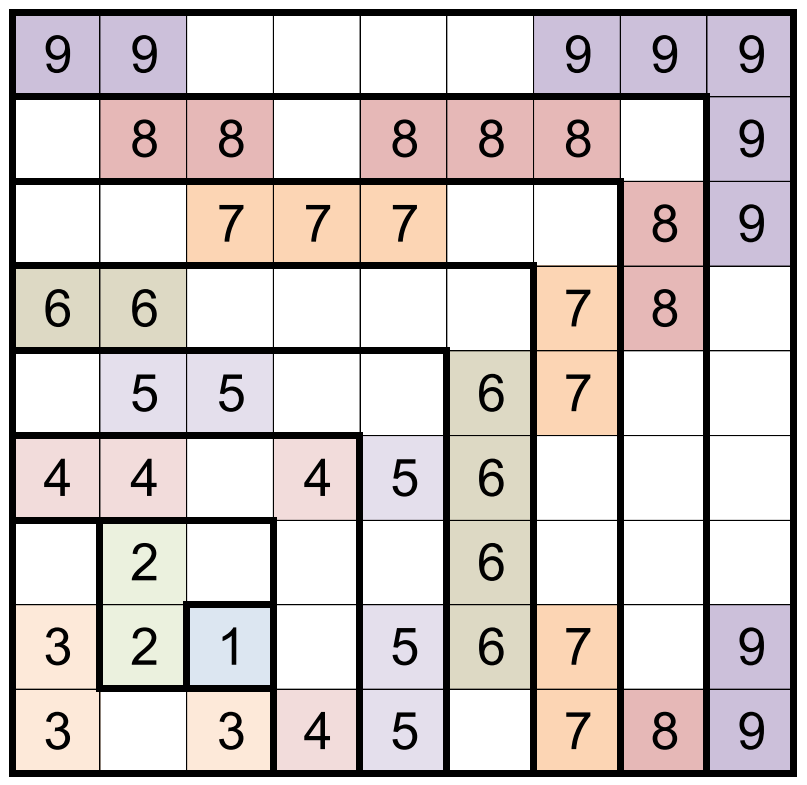

### Hooks #4

The completed grid is shown to the left. The product of the areas of the regions
of blank squares is
6000
.

In [8]:
url='https://www.janestreet.com/puzzles/hooks-4-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
display(Markdown('### Solution as published \n'+url))
display(Image('https://www.janestreet.com/puzzles/20180801_hooks_4_ans.png',width=200))
y =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(y)])
display(Markdown("### "+y[8]+"\n\n"+str("\n".join(y[11:14]))))